# 示例：Dynex平台上的RNA折叠

在生物学和化学中，分子的性质不仅仅由一组原子决定，还由分子的形状决定。在遗传学中，RNA分子的形状主要由其自身的弯曲决定。组成RNA的A、U、G和C序列具有一些被吸引在一起形成氢键的配对。连续几个键的序列称为干，干提供足够的力将分子折叠在一起。RNA分子自然形成一些干，同时避免其他干，以最小化系统的自由能。

该演示程序接受一个RNA序列，并应用二次模型来寻求最佳的干配置。

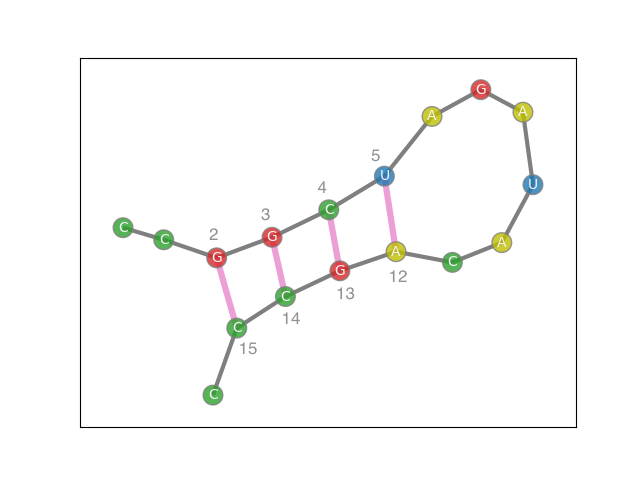
图1 - 一个长度为4的单干RNA序列

预测RNA分子中干的存在对于预测RNA分子的性质非常重要。然而，预测受到两个重要因素的复杂性的影响。

首先，干不允许重叠。图1可以说明重叠的简单情况。由粉色线表示的干可以用元组（2, 5, 12, 15）表示。在这里，索引从最左边的C开始，沿着灰色边表示的序列继续，以底部最下面的C处的索引16结束。图中标记了干中八个核苷酸的索引。四条粉色边说明了构成干的四个键。虽然干中有八个核苷酸，沿着粉色线结合在一起，但4元组完全确定了干。然而，还需要考虑较小的干(2, 4, 13, 15)和(3, 5, 12, 14)，即使在这种情况下最优解不包括它们。请注意，默认情况下，我们只考虑长度至少为3的干，因为较小的干不太可能形成并维持键。

其次，伪结对现象称为伪结对不太有利。在图2中，我们看到了这样一个伪结对的例子，在这个例子中，一个干的一侧出现在另一个干的两侧之间。使用二次目标函数可以使伪结对在最优解中不太可能出现，从而提高整体准确性。具体而言，我们为每对构成伪结对的干包括一个二次项。这个二次项上的正系数会阻止形成伪结对，而不明确禁止它们。

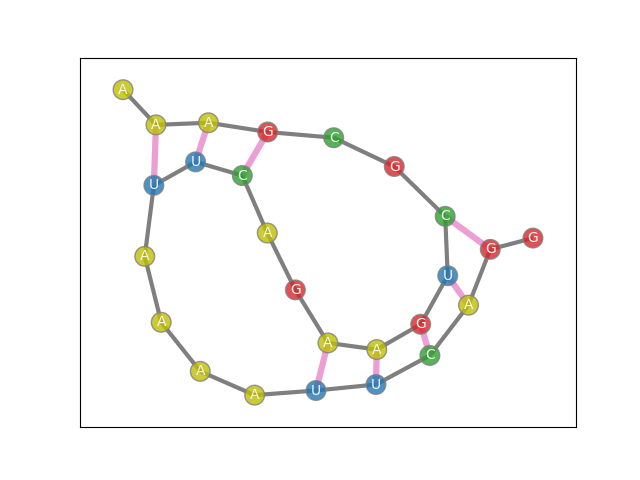
 图2 - 由长度为3的干和长度为5的干形成的伪结对。

这个演示程序基于[1]中的工作，而[1]又受到[2]的启发。

## 问题表述

在预测RNA分子中干的情况下，我们建立了一个具有三个贡献因素的二次模型。

1. 每个可能的干都被编码为一个二进制变量，其权重为长度的负平方，k。

2. 每个可能的伪结对都被编码为一个二次项，其权重为两个长度的乘积乘以一个正参数c。

3. 不允许干重叠。潜在的重叠会在模型中引起约束。

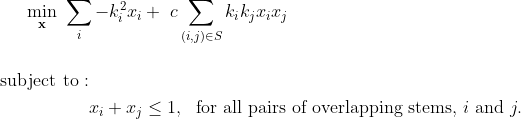

在这里，每个xi是一个二进制变量，表示第i个干的包含/排除情况。每个常数ki是该干的长度。索引集合S是形成伪结对的所有干对的集合。最后，c是一个可调参数，用于调整伪结对的影响。默认情况下，它设置为0.3。如果c = 0，将忽略伪结对的影响，而c > 1将从最优解中消除所有伪结对。这个公式（和默认的c选择）基于[1]。

在打印的解决方案中，每个干由四个数字表示。前两个数字对应于干的第一侧的起始索引和结束索引。类似地，最后两个数字对应于干的第二侧的起始索引和结束索引。

## 代码细节

默认情况下，最小干的长度设置为3。因此，长度为5的干包含两个长度为4的干和三个长度为3的干。干字典将最大干（在包含关系下）记录为键，其中每个键映射到一个与最大干弱包含在内的相关干的列表。

同一最大键中包含的两个干不能同时出现在最优解中，因此我们将它们全部视为重叠，而不管实际情况如何。通过使用add_discrete方法，将包含在最大干中的干集合视为单个离散变量来强制执行这种特定的重叠情况。

我们进一步利用干字典结构，在搜索伪结对和重叠时避免比较所有干的组合。

绘图使用随机过程来找到合理的布局。因此，即使解决方案没有改变，连续运行时绘图也会发生变化。

输入文本文件应该在每一行的开头有一个数字，后面跟着一串A、C、G、U和T的序列。文件读取器忽略前导数字，并且不对空格、大小写或换行符敏感。按照惯例，空格用于每10个字母之间的分隔，并且每行开头的数字用于跟踪序列中的位置。例如，如果每行有30个字母，则每行将有三组10个字母，并且每行开头的数字将增加30。

## 参考

[1] Fox DM, MacDermaid CM, Schreij AM, Zwierzyna M, Walker RC. 《使用量子计算机折叠RNA》, PLOS Computational Biology.

[2] Kai, Zhang, et al. 《一种用于带有伪结对的RNA二级结构预测的高效模拟退火算法》 BMC Genomics.

## 代码

In [13]:
from collections import defaultdict
from itertools import product, combinations
import click
import matplotlib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import dynex
import dimod

## 辅助函数

读取格式正确的RNA文本文件，并返回可能的氢键配对矩阵：

In [14]:
def text_to_matrix(file_name, min_loop):
    """ 读取格式正确的RNA文本文件，并返回可能的氢键配对矩阵：

    参数：

        file_name (str)：文本文件路径。
        min_loop (int)：分隔一个干两侧的核苷酸最小数目。
    返回值：

        :class: numpy.ndarray：由0和1组成的Numpy矩阵，其中1表示可能的配对。
    """

    # 需要使用与示例相同格式的RNA数据文本文件。
    with open(file_name) as f:
        rna = "".join(("".join(line.split()[1:]) for line in f.readlines())).lower()

    # 创建包含每个核苷酸出现的所有索引的字典。
    index_dict = defaultdict(list)

    # 创建一个给出每个核苷酸索引列表的字典。
    for i, nucleotide in enumerate(rna):
        index_dict[nucleotide].append(i)

    # 为干列出可能的氢键。
    # 请注意，有时会使用“t”代替“u”。
    hydrogen_bonds = [('a', 't'), ('a', 'u'), ('c', 'g'), ('g', 't'), ('g', 'u')]

    # 创建一个上三角0/1矩阵，指示可能发生键合的位置。
    bond_matrix = np.zeros((len(rna), len(rna)), dtype=bool)
    for pair in hydrogen_bonds:
        for bond in product(index_dict[pair[0]], index_dict[pair[1]]):
            if abs(bond[0] - bond[1]) > min_loop:
                bond_matrix[min(bond), max(bond)] = 1

    return bond_matrix


接受一个可能的氢键配对矩阵，并返回一个可能干的字典。

In [15]:
def make_stem_dict(bond_matrix, min_stem, min_loop):
    """ 接受一个可能的氢键配对矩阵，并返回一个可能干的字典。

    干字典将最大干（在包含关系下）记录为键，其中每个键映射到一个与最大干弱包含在内的相关干的列表。以这种方式记录干，可以加快计算速度

    参数：

        bond_matrix (:class: numpy.ndarray)：由0和1组成的Numpy矩阵，其中1表示可能的配对。
        min_stem (int)：每侧干中的核苷酸最小数目。
        min_loop (int)：分隔一个干两侧的核苷酸最小数目。
    返回值：

        dict：所有可能的干的字典，最大干作为键。
    """

    stem_dict = {}
    n = bond_matrix.shape[0]

    # 遍历矩阵，寻找可能的干。
    for i in range(n + 1 - (2 * min_stem + min_loop)):
        for j in range(i + 2 * min_stem + min_loop - 1, n):
            if bond_matrix[i, j]:
                k = 1
                # 向下和向左检查干的长度。
                # 请注意，bond_matrix严格是上三角形的，因此循环将终止。
                while bond_matrix[i + k, j - k]:
                    bond_matrix[i + k, j - k] = False
                    k += 1

                if k >= min_stem:
                    # 使用4元组表示干。
                    stem_dict[(i, i + k - 1, j - k + 1, j)] = []

    # 遍历在包含关系下弱包含在最大干中的所有子干。
    for stem in stem_dict.keys():
        stem_dict[stem].extend([(stem[0] + i, stem[0] + k, stem[3] - k, stem[3] - i)
                                for i in range(stem[1] - stem[0] - min_stem + 2)
                                for k in range(i + min_stem - 1, stem[1] - stem[0] + 1)])

    return stem_dict

检查两个干是否使用了相同的核苷酸：

In [16]:
def check_overlap(stem1, stem2):
    """检查两个干是否使用了相同的核苷酸。

    参数：

        stem1 (tuple)：包含干信息的4元组。
        stem2 (tuple)：包含干信息的4元组。
    返回值：

        bool：表示两个干是否重叠的布尔值
    """

    # 检查在实现离散变量时使用的字符串虚拟变量。
    if type(stem1) == str or type(stem2) == str:
        return False

    # 检查stem2的任何端点是否与stem1重叠。
    for val in stem2:
        if stem1[0] <= val <= stem1[1] or stem1[2] <= val <= stem1[3]:
            return True
    # 检查stem1的端点是否与stem2重叠。
    # 不需要检查所有的stem1端点。
    for val in stem1[1:3]:
        if stem2[0] <= val <= stem2[1] or stem2[2] <= val <= stem2[3]:
            return True

    return False


创建一个字典，其中所有可能的伪结对作为键，适当的惩罚作为值。惩罚是参数c乘以结中两个干的长度的乘积。

In [17]:
def pseudoknot_terms(stem_dict, min_stem=3, c=0.3):
    """ 创建一个字典，其中所有可能的伪结对作为键，适当的惩罚作为值。

    惩罚是参数c乘以结中两个干的长度的乘积。

    参数：

        stem_dict (dict)：最大干作为键，弱包含子干列表作为值的字典。
        min_stem (int)：被视为干的最小连续键数。
        c (float)：伪结对惩罚的参数因子。
    返回值：

        dict：所有可能的伪结对作为键，适当的惩罚作为值对的字典。
    """

    pseudos = {}
    # 在所有最大干对中查找可能的伪结对。
    for stem1, stem2 in product(stem_dict.keys(), stem_dict.keys()):
        # 使用乘积而不是组合，可以进行短的不对称检查。
        if stem1[0] + 2 * min_stem < stem2[1] and stem1[2] + 2 * min_stem < stem2[3]:
            pseudos.update({(substem1, substem2): c * (1 + substem1[1] - substem1[0]) * (1 + substem2[1] - substem2[0])
                            for substem1, substem2
                            in product(stem_dict[stem1], stem_dict[stem2])
                            if substem1[1] < substem2[0] and substem2[1] < substem1[2] and substem1[3] < substem2[2]})
    return pseudos

创建一个受限二次模型，以优化可能干的字典中最可能的干：

In [18]:
def build_cqm(stem_dict, min_stem, c):
    """ 创建一个受限二次模型，以优化可能干的字典中最可能的干：

    参数：

        stem_dict (dict)：最大干作为键，弱包含子干列表作为值的字典。
        min_stem (int)：被视为干的最小连续键数。
        c (float)：伪结对惩罚的参数因子。
    返回值：

        :class:~dimod.ConstrainedQuadraticModel：RNA折叠的优化模型。
    """

    # 创建线性系数为-k^2，优先考虑长干的包含关系。
    # 我们在这个公式中与参考文献不同。
    linear_coeffs = {stem: -1 * (stem[1] - stem[0] + 1) ** 2 for sublist in stem_dict.values() for stem in sublist}

    # 为重叠和子干包含创建约束。
    quadratic_coeffs = pseudoknot_terms(stem_dict, min_stem=min_stem, c=c)

    bqm = dimod.BinaryQuadraticModel(linear_coeffs, quadratic_coeffs, 'BINARY')

    cqm = dimod.ConstrainedQuadraticModel()
    cqm.set_objective(bqm)

    # 添加约束，禁止包含在同一最大干中的重叠子干。
    for stem, substems in stem_dict.items():
        if len(substems) > 1:
            # 在一次热约束中添加所有零情况的变量。
            zeros = 'Null:' + str(stem)
            cqm.add_variable(zeros, 'BINARY')
            cqm.add_discrete(substems + [zeros], stem)

    for stem1, stem2 in combinations(stem_dict.keys(), 2):
        # 首先检查最大干。
        if check_overlap(stem1, stem2):
            # 如果最大干重叠，则比较较小干的列表。
            for stem_pair in product(stem_dict[stem1], stem_dict[stem2]):
                if check_overlap(stem_pair[0], stem_pair[1]):
                    cqm.add_constraint(dimod.quicksum([dimod.Binary(stem) for stem in stem_pair]) <= 1)

    return cqm

## RNA折叠示例：烟草花叶病毒。

文件夹'rna-data'包含多个RNA序列，包括HIV病毒。为了演示目的，我们使用的是"烟草花叶病毒"（Tobamovirus）。

https://rnavlab.utep.edu/static/PKB_files/PKB92

默认情况下，最小干的长度设置为3。因此，长度为5的干包含两个长度为4的干和三个长度为3的干。干字典将最大干（在包含关系下）记录为键，其中每个键映射到一个与最大干弱包含在内的相关干的列表。

在同一个最大键中包含的两个干不能同时在最优解中，因此我们将它们全部视为重叠的，而不管实际情况如何。通过使用add_discrete方法，我们将包含在最大干中的干集合视为单个离散变量，从而强制执行这种特定的重叠情况。

我们进一步利用干字典结构，在搜索伪结对和重叠时避免比较所有干的组合。首先，我们定义参数：

In [19]:
# 定义参数：
path     = "rna-data/TMGMV_UPD-PK1.txt"
min_stem = 3 # 被视为干的最小长度
min_loop = 2 # 干两侧之间的最小核苷酸数
c = 0.3      # 伪结对二次项系数的乘数

然后我们加载RNA序列并将其转换为矩阵。输入文本文件的每一行开头应该有一个数字，后面跟着一串A、C、G、U和T的序列。文件阅读器忽略开头的数字，对空格、大小写或换行不敏感。按照惯例，空格用于每10个字母之间的分隔，并且每行开头的数字用于跟踪序列中的位置。例如，如果每行有30个字母，则每行将有三组10个字母，每行开头的数字增加30。

In [20]:
# 加载RNA序列：
matrix = text_to_matrix(path, min_loop)
stem_dict = make_stem_dict(matrix, min_stem, min_loop)

该问题可以表示为一个受限二次模型（CQM）。

In [21]:
cqm = build_cqm(stem_dict, min_stem, c)

C:\Users\Theresa\AppData\Local\Temp\ipykernel_18024\2742969760.py:31: DeprecationWarning: Parameter order CQM.add_variable(v, vartype) is deprecated since dimod 0.11.0 and will be removed in 0.13.0. Use CQM.add_variable(vartype, v) instead.
  cqm.add_variable(zeros, 'BINARY')


二进制二次模型（BQM）和受限二次模型之间可以很容易地相互转换。这里返回一个包含二进制二次模型和一个将样本从二进制二次模型转换回受限二次模型的函数的2元组：

In [22]:
bqm, invert = dimod.cqm_to_bqm(cqm) # CQM->BQM

接下来，我们使用Ising/QUBU采样在Dynex神经形态平台上对（转换后的）CQM问题进行采样，以找到具有最低能量的最优状态。我们选择在1024个单独的Dynex芯片上运行计算，最大积分时间为1000步。请注意，Dynex平台支持多达1.5亿个单独的Dynex芯片（在编写本示例时）。

In [23]:
# 在Dynex上运算:
model = dynex.BQM(bqm);
sampler = dynex.DynexSampler(model,  mainnet=True, description='RNA_Folding_By_Rumony')

In [24]:
sampleset = sampler.sample(num_reads=1024, annealing_time = 1000);
# sample_set = invert(sampler.assignments); #返回到 CQM variable classes

╭────────────┬───────────┬────────────────┬─────────┬─────────┬────────────────╮
│   DYNEXJOB │   ELAPSED │   WORKERS READ │   CHIPS │   STEPS │   GROUND STATE │
├────────────┼───────────┼────────────────┼─────────┼─────────┼────────────────┤
│       7773 │      0.41 │              1 │    1024 │    1000 │      201525.00 │
╰────────────┴───────────┴────────────────┴─────────┴─────────┴────────────────╯
╭───────────┬───────────────┬─────────┬───────┬───────────┬───────────┬───────────────┬──────────╮
│    WORKER │       VERSION │   CHIPS │   LOC │    ENERGY │   RUNTIME │   LAST UPDATE │   STATUS │
├───────────┼───────────────┼─────────┼───────┼───────────┼───────────┼───────────────┼──────────┤
│ 165525129 │ 2.3.0.OZM.125 │    1024 │     8 │ 201525.00 │  0.05 min │     7.00s ago │  STOPPED │
╰───────────┴───────────────┴─────────┴───────┴───────────┴───────────┴───────────────┴──────────╯
[DYNEX] FINISHED READ AFTER 0.42 SECONDS
[DYNEX] COMPUTING FILE b5cc8f0135b1462c5effa6c3c1ae8456.bin

sampler.assignments 包含Dynex采样器找到的最佳分配。我们将使用此分配来提取干并查找伪结对：

In [25]:
# 提取最佳可行样本
solution =  sampleset.first.sample

# 使用正指示变量提取干。
bonded_stems = [stem for stem, val in solution.items() if val == 1 and type(stem) == tuple]

print('\nNumber of stems in best solution:', len(bonded_stems))
print('Stems in best solution:', *bonded_stems)

print('\nNumber of variables (stems):', len(solution))

# 使用乘积而不是组合查找伪结对，可以进行短的不对称检查。
pseudoknots = [(stem1, stem2) for [stem1, stem2] in product(bonded_stems, bonded_stems)
               if stem1[1] < stem2[0] and stem2[1] < stem1[2] and stem1[3] < stem2[2]]

print('\nNumber of pseudoknots in best solution:', len(pseudoknots))
if pseudoknots:
    print('Pseudoknots:', *pseudoknots)



Number of stems in best solution: 2
Stems in best solution: (7, 11, 21, 25) (1, 5, 12, 16)

Number of variables (stems): 51

Number of pseudoknots in best solution: 1
Pseudoknots: ((1, 5, 12, 16), (7, 11, 21, 25))


现在我们将可视化找到的解决方案。请注意，绘图使用随机过程来找到合理的布局。因此，即使解决方案没有改变，连续运行时绘图也会发生变化。

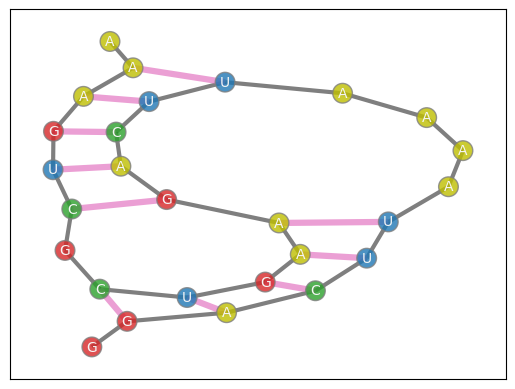

In [26]:
with open(path) as f:
    rna = "".join(("".join(line.split()[1:]) for line in f.readlines())).lower()
    
# 创建带有RNA序列和干边缘的图。节点暂时用整数标记。
G = nx.Graph()
rna_edges = [(i, i + 1) for i in range(len(rna) - 1)]
stem_edges = [(stem[0] + i, stem[3] - i) for stem in bonded_stems for i in range(stem[1] - stem[0] + 1)]
G.add_edges_from(rna_edges + stem_edges)

# 将每个核苷酸分配给一个颜色。
color_map = []
for node in rna:
    if node == 'g':
        color_map.append('tab:red')
    elif node == 'c':
        color_map.append('tab:green')
    elif node == 'a':
        color_map.append('y')
    else:
        color_map.append('tab:blue')

options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.8}

pos = nx.spring_layout(G, iterations=5000)  # max(3000, 125 * len(rna)))
nx.draw_networkx_nodes(G, pos, node_color=color_map, **options)
labels = {i: rna[i].upper() for i in range(len(rna))}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="whitesmoke")
nx.draw_networkx_edges(G, pos, edgelist=rna_edges, width=3.0, alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=stem_edges, width=4.5, alpha=0.7, edge_color='tab:pink')